In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
sys.path.insert(0, '../')

import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from mnist_train import Net
from utils.gpu_utils import restrict_GPU_pytorch
from utils.imagenet_utils import accuracy
from utils.dataloading_utils import MyIter, MyLoader
from new_tta_models import ImageDeferral, ClassWeights, AugWeights, StandardTTA, Original

restrict_GPU_pytorch('1')

Using GPU:0
Using GPU:1


# Loading pre-trained model

In [63]:
from mnist_train import Net

pcts = [.005, .01, .05, .075,  .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
pct = .005
model = Net()
model.load_state_dict(torch.load('../saved_models/mnist/mnist_cnn_' + str(pct) + '.pth'))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Defining dataloaders 

In [76]:
dataset = datasets.MNIST('../datasets', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
hflip_dataset = datasets.MNIST('../datasets', download=True, train=False, transform=transforms.Compose([
                           transforms.RandomHorizontalFlip(p=1),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))
vflip_dataset = datasets.MNIST('../datasets', download=True, train=False, transform=transforms.Compose([
                           transforms.RandomVerticalFlip(p=1),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))

n_examples = len(dataset)
subset_indices = np.arange(n_examples)
np.random.shuffle(subset_indices)
val_idxs = subset_indices[:int(len(subset_indices)/2)]
test_idxs = subset_indices[int(len(subset_indices)/2):]
batch_size = 512
n_augs = 3
orig_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, val_idxs), 
        batch_size=batch_size, shuffle=False)
hflip_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(hflip_dataset, val_idxs),
                                                batch_size=batch_size, shuffle=False)
vflip_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(vflip_dataset, val_idxs),
                                                batch_size=batch_size, shuffle=False)
data_loader = MyLoader([orig_val_loader, hflip_val_loader, vflip_val_loader])


orig_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, test_idxs), 
        batch_size=batch_size, shuffle=False)
hflip_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(hflip_dataset, test_idxs),
                                                batch_size=batch_size, shuffle=False)
vflip_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(vflip_dataset, test_idxs),
                                                batch_size=batch_size, shuffle=False)
test_data_loader = MyLoader([orig_test_loader, hflip_test_loader, vflip_val_loader])

In [6]:
def_model = ImageDeferral(model,n_augs, 10, 0, 1)
def_model.cuda('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
criterion.cuda('cuda:0')
optimizer = torch.optim.SGD(def_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)


losses = []
acc1s = []
acc5s = []
epochs = 10
for epoch in range(epochs):
    for examples, target in data_loader:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)
        output = def_model(examples)
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        acc1s.append(acc1.item())
        acc5s.append(acc5.item())

In [7]:
def_model.eval()
def_model.cuda('cuda:0')
model.cuda('cuda:0')
test_acc1s = []
test_acc5s = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = def_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

91.35164184570313 99.34510498046875


# Evaluation learning augmentation weights

In [87]:
model = Net()
model.load_state_dict(torch.load('../saved_models/mnist/mnist_cnn.pth'))
model.eval()
aug_model = ClassWeights(model, n_augs, 10)
aug_model.cuda('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
criterion.cuda('cuda:0')
optimizer = torch.optim.SGD(aug_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)

losses = []
acc1s = []
acc5s = []
epochs = 50
for epoch in range(epochs):
    for examples, target in data_loader:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)
        output = aug_model(examples)
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        acc1s.append(acc1.item())
        acc5s.append(acc5.item())

In [88]:
aug_model.eval()
test_acc1s = []
test_acc5s = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = aug_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

31.147161865234374 93.78706970214844


In [89]:
aug_model.sm(aug_model.w)

tensor([[0.3564, 0.6898, 0.3547, 0.4859, 0.4206, 0.3544, 0.3791, 0.2914, 0.3588,
         0.3574],
        [0.3218, 0.1594, 0.3227, 0.2647, 0.2897, 0.3207, 0.3105, 0.4173, 0.3206,
         0.3213],
        [0.3218, 0.1508, 0.3227, 0.2494, 0.2897, 0.3248, 0.3105, 0.2914, 0.3206,
         0.3213]], device='cuda:0', grad_fn=<SoftmaxBackward>)

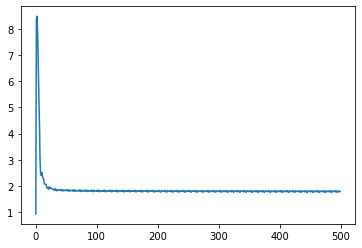

In [90]:
import matplotlib.pyplot as plt
plt.plot(losses)

# Evaluating original model

In [81]:
# See how regular TTA works with this
# See how learning just the weights does
model = Net()
model.load_state_dict(torch.load('../saved_models/mnist/mnist_cnn.pth'))
model.eval()
orig_model = Original(model, 0)
orig_model.cuda('cuda:0')
orig_model.eval()
test_acc1s = []
test_acc5s = []
all_orig_preds = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = orig_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    all_orig_preds.extend(np.argmax(output.cpu().numpy(), 1))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

96.6876594543457 99.91589584350587


# Evaluting standard test-time augmentation


In [82]:
stta_model = StandardTTA(model)
stta_model.cuda('cuda:0')
test_acc1s = []
test_acc5s = []
all_targets = []
all_stta_preds = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = stta_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    all_stta_preds.extend(np.argmax(output.cpu().numpy(), 1))
    all_targets.extend(target.cpu().numpy())
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

78.13376922607422 98.77431411743164


In [54]:
all_stta_preds = np.array(all_stta_preds)
all_targets = np.array(all_targets)
all_orig_preds = np.array(all_orig_preds)
stta_correct = np.where(all_stta_preds == all_targets)[0]
stta_incorrect = np.where(all_stta_preds != all_targets)[0]
orig_correct = np.where(all_orig_preds == all_targets)[0]
orig_incorrect = np.where(all_orig_preds != all_targets)[0]
len(set(stta_correct).intersection(orig_incorrect)), len(set(orig_correct).intersection(stta_incorrect))

(36, 569)

In [55]:
len(orig_correct)

4839

# Learning augmentation specific weights

In [70]:
# Filter to just ones
one_idxs = np.where(dataset.targets == 8)[0]
one_orig_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, one_idxs), 
        batch_size=batch_size, shuffle=False)
one_hflip_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(hflip_dataset, one_idxs),
                                                batch_size=batch_size, shuffle=False)
one_vflip_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(vflip_dataset, one_idxs),
                                                batch_size=batch_size, shuffle=False)
one_data_loader = MyLoader([one_orig_loader, one_hflip_loader])
# Original accuracy
# See how regular TTA works with this
# See how learning just the weights does
orig_model = Original(model, 0)
orig_model.cuda('cuda:0')
orig_model.eval()
test_acc1s = []
test_acc5s = []
for examples, target in one_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = orig_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

# See if horizontal flips help
stta_model = StandardTTA(model)
stta_model.cuda('cuda:0')
test_acc1s = []
test_acc5s = []
for examples, target in one_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = stta_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

94.35157775878906 99.90234375
96.34698104858398 100.0


Using GPU:0


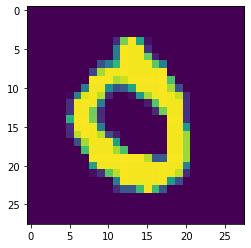

In [62]:
orig = next(iter(one_data_loader))
ex = orig[0][0][0]
plt.imshow(orig[0][1][0][0])

In [ ]:
ex = orig[0][1].cuda()
model(ex)[0]

# See if learning a class-conditional model works

In [137]:
# Learn weights directly from image, and just learn 

array([   2,    5,   14, ..., 9978, 9984, 9994])